<a href="https://colab.research.google.com/github/Jun-629/DS502/blob/master/Project/Data_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import scipy.stats as st
import xgboost as xgb
import random as rd
import csv
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# %matplotlib inline
#pd.option.display.max_rows = 1000
#pd.option.display.max_coloums = 20

In [3]:
!git clone https://github.com/Jun-629/DS502.git
!ls -R

Cloning into 'DS502'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.
.:
DS502  sample_data

./DS502:
LICENSE  Project  README.md

./DS502/Project:
data_description.txt  Data_Process.ipynb  train.csv
Data_process.ipynb    test.csv

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [0]:
data0 = pd.read_csv('./DS502/Project/train.csv')

Id = data0['Id']          # Save the 'Id' column before drop it
SalePrice = data0.SalePrice    # Save the 'SalePrice' column before drop it
data = data0.drop(['Id','SalePrice'], axis = 1)  # the data set with only factors we may need

- Visualize the features in the dataset.

In [209]:
# Finding numeric features

numeric_dtypes = ['int64', 'float64']
numeric = []
for i in data.columns:
  if data[i].dtype in numeric_dtypes:
    #if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
      #pass
    #else:
    numeric.append(i)
print(numeric)          # The numeric variables with 36 terms

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [210]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(len(missing_data))

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


- **PoolQC:** Pool quality.

The data description shows that 'NA' means "No Pool", which makes sense. However, given the huge ratio of missing value ($>99\%$), the majority of houses have no Pool at all in general. So we choose to drop this variable as well as the variable **PoolArea**, which means the pool area in square feet.

In [0]:
PoolArea = data.PoolArea    # Save the 'PoolArea' column before drop it
PoolQC = data.PoolQC      
data = data.drop(['PoolArea','PoolQC'], axis=1)

- **MiscFeature:** Miscellaneous feature not covered in other categories.

The data description shows that 'NA' means "None", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
data["MiscFeature"] = data["MiscFeature"].fillna("None")

- **Alley:** Type of alley access to property.

The data description shows that 'NA' means "No alley access", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
data["Alley"] = data["Alley"].fillna("None")

- **Fence:** Fence quality.

The data description shows that 'NA' means "No Fence", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
data["Fence"] = data["Fence"].fillna("None")

- **FireplaceQu:** Fireplace quality.

The data description shows that 'NA' means "No Fireplace", which makes sense. And also, this is the categorical variable, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

- **LotFrontage:** Linear feet of street connected to property.

This is the numerical variable. Thus "NA" shows that these data are missed. Besides, the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we decide to fill in the missing data by the median **LotFrontage** of the neighborhood.

In [0]:
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond:** Garage Location, Interior finish of the Garage, Garage Quality and Garage Condition respectively.

The data description shows that 'NA' means "No Garage", which makes sense. And also, these are the categorical variables, we will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
for grg_cate in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[grg_cate] = data[grg_cate].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars:** Year Garage built, Size of Garage and Car Capacity of Garage respectively.

These three variables are numerical variables, while combined with other four variables shown before, we can know that here "NA" also means that there is no Garage. However, we can not replace "NA" with "None" due to the attribute of numeric. Here, we decide to fill in these data by 0, which also means that "No Garage".

In [0]:
for grg_num in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[grg_num] = data[grg_num].fillna(0)

##### 这里  感觉我们还要在考虑一下， 我搜了原来的train data
##### garageArea & Cars 的那两个变量  其实本身就是0
##### 但是 GarageYrBuilt 的那个 年份如果变成0的话
##### 别的都是19xx, 20xx 那如果这样考虑的话， 那会不会影响太大
##### 还是说考虑到这个变量的话，可能他的系数就很小，也没关系嘛？还是什么
##### 我在下面看到了year sold，把那个改成了categorical的了，我把这个也改了

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2:** Height of Basement, Condition of Basement, Walkout or Garden Level Walls, Rating of Basement Finished Area 1&2 respectively.

For all these categorical basement-related features, the data description shows that "NA" means "No Basement". We will change "NA" into "None" so that we will not be confused by this symbol with null data.

In [0]:
for bsmt in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[bsmt] = data[bsmt].fillna('None')

- **MasVnrType and MasVnrArea:** Masonry Veneer Type and  Masonry Veneer Area.

In the data description, there is no "NA" type. Thus, we regard this as "None", since the corresponding variable **MasVnrArea** also shows "NA". And we will replace the latter variable with 0.

In [0]:
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

- **Electrical:** Electrical System.

It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [0]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [222]:
# Check if there still be any missing value

data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(10)

,Missing Ratio


- However, after dealing with some missing data, we need to process some numerical variables which actually are the categorical ones, such as **MSSubclass** (Identifies the type of dwelling involved in the sale.), **OverallQual** (the overall material and finish of the house), **OverallCond** (the overall condition of the house), **GarageYrBlt** (Year garage built),  **YrSold** (Year Sold) and **MoSold** (Month Sold)

In [0]:
data['MSSubClass'] = data['MSSubClass'].apply(str)

data['OverallCond'] = data['OverallCond'].astype(str)
data['OverallQual'] = data['OverallQual'].astype(str)

data['GarageYrBlt'] = data['GarageYrBlt'].astype(str)

data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

In [226]:
# Split the training data set and the test one.

train_data, test_data, train_SP, test_SP = train_test_split(data, SalePrice, test_size = 0.3)
print(train_data)

     MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
755         160       FV         34.0  ...    2009       WD        Normal
66           20       RL         73.0  ...    2010       WD        Normal
1039        180       RM         21.0  ...    2009       WD        Normal
43           20       RL         70.0  ...    2008       WD        Normal
1024         20       RL         85.0  ...    2008      COD       Abnorml
...         ...      ...          ...  ...     ...      ...           ...
731          80       RL         73.0  ...    2007       WD        Normal
171          20       RL        141.0  ...    2010       WD        Normal
1157        120       RL         34.0  ...    2009       WD        Normal
416          60       RL         74.0  ...    2006       WD        Normal
136          20       RL         73.0  ...    2007       WD        Normal

[1022 rows x 77 columns]


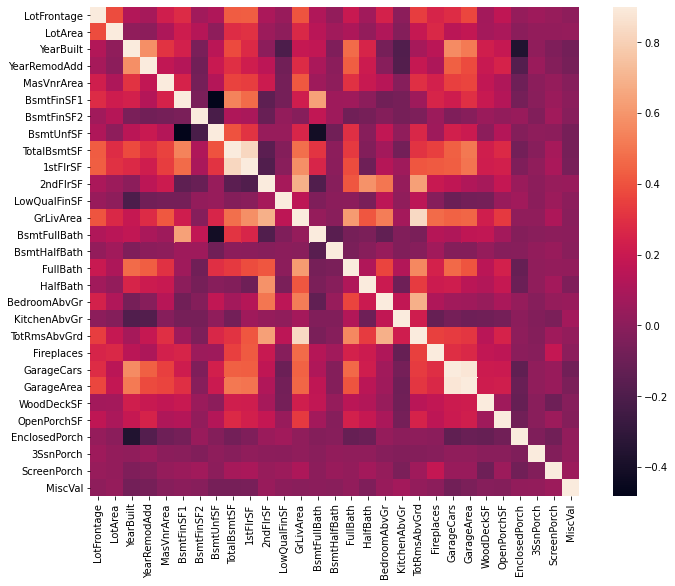

In [227]:
corrmat = train_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [158]:
# Split the data set into training one and test one with the ratio 7:3.
# 这个没啥用了  我只是现在这里放着。


name = list(data.columns)
data_list = data.values.tolist()
Id_list = Id.values.tolist()

np.random.seed(1)
train_Id = np.random.choice(Id, size = round(0.7 * data.shape[0]),replace=False)
train_Id.sort()
train = []
for i in train_Id:
  Id_list.remove(i)   ######## cannot make a new list, otherwise it will be NONE
                          #### Now Id_list is the Id number of the test data
for i in train_Id:
  train.append(data_list[i-1])
newtrain = pd.DataFrame(train, index = train_Id, columns = name)
print(newtrain)

      MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
1             60       RL         65.0  ...    2008       WD        Normal
2             20       RL         80.0  ...    2007       WD        Normal
3             60       RL         68.0  ...    2008       WD        Normal
4             70       RL         60.0  ...    2006       WD       Abnorml
6             50       RL         85.0  ...    2009       WD        Normal
...          ...      ...          ...  ...     ...      ...           ...
1451          90       RL         60.0  ...    2009       WD        Normal
1452          20       RL         78.0  ...    2009      New       Partial
1454          20       RL         90.0  ...    2006       WD       Abnorml
1455          20       FV         62.0  ...    2009       WD        Normal
1458          70       RL         66.0  ...    2010       WD        Normal

[1022 rows x 79 columns]
